In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [9]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = 'input/'

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 256

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [15]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print(device)

cuda:0


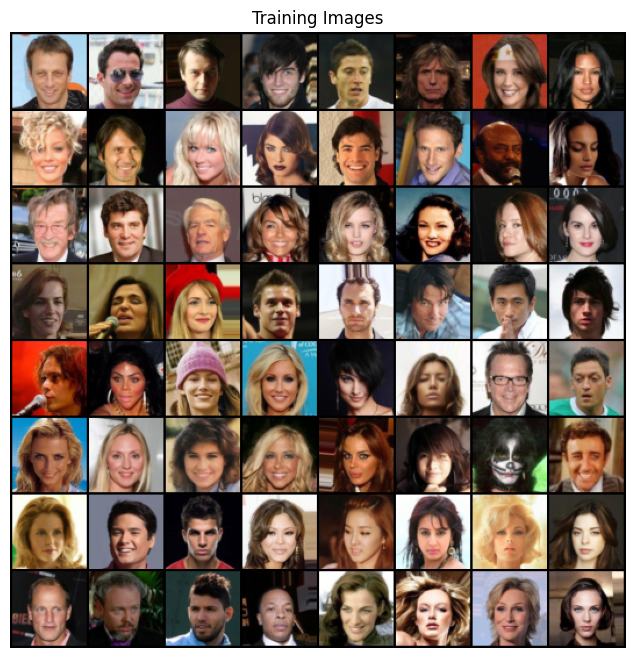

In [16]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [17]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [18]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




In [19]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator Code



In [3]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [21]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [22]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [23]:

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()


        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/50][0/792]	Loss_D: 2.0314	Loss_G: 5.1491	D(x): 0.5706	D(G(z)): 0.6853 / 0.0093
[0/50][50/792]	Loss_D: 0.2175	Loss_G: 19.1993	D(x): 0.8912	D(G(z)): 0.0000 / 0.0000
[0/50][100/792]	Loss_D: 1.2513	Loss_G: 7.0710	D(x): 0.4717	D(G(z)): 0.0033 / 0.0024
[0/50][150/792]	Loss_D: 1.3852	Loss_G: 2.3560	D(x): 0.4117	D(G(z)): 0.0157 / 0.1831
[0/50][200/792]	Loss_D: 0.5391	Loss_G: 4.5874	D(x): 0.9105	D(G(z)): 0.2796 / 0.0295
[0/50][250/792]	Loss_D: 0.5775	Loss_G: 4.1552	D(x): 0.8041	D(G(z)): 0.2607 / 0.0291
[0/50][300/792]	Loss_D: 0.5412	Loss_G: 3.7051	D(x): 0.8202	D(G(z)): 0.2425 / 0.0491
[0/50][350/792]	Loss_D: 0.5496	Loss_G: 3.7860	D(x): 0.8730	D(G(z)): 0.2866 / 0.0498
[0/50][400/792]	Loss_D: 1.0507	Loss_G: 6.3659	D(x): 0.8548	D(G(z)): 0.5232 / 0.0040
[0/50][450/792]	Loss_D: 0.4656	Loss_G: 4.2129	D(x): 0.8097	D(G(z)): 0.1622 / 0.0238
[0/50][500/792]	Loss_D: 0.6420	Loss_G: 5.1658	D(x): 0.9542	D(G(z)): 0.3836 / 0.0124
[0/50][550/792]	Loss_D: 0.5532	Loss_G: 4.1507	D(x): 

[6/50][100/792]	Loss_D: 0.6965	Loss_G: 1.5970	D(x): 0.6027	D(G(z)): 0.1202 / 0.2422
[6/50][150/792]	Loss_D: 0.8873	Loss_G: 1.0697	D(x): 0.5025	D(G(z)): 0.0963 / 0.3872
[6/50][200/792]	Loss_D: 0.5466	Loss_G: 2.3341	D(x): 0.7717	D(G(z)): 0.2222 / 0.1226
[6/50][250/792]	Loss_D: 0.6519	Loss_G: 1.3718	D(x): 0.6197	D(G(z)): 0.1155 / 0.2852
[6/50][300/792]	Loss_D: 1.7955	Loss_G: 0.1016	D(x): 0.2198	D(G(z)): 0.0338 / 0.9121
[6/50][350/792]	Loss_D: 0.7417	Loss_G: 2.5830	D(x): 0.7893	D(G(z)): 0.3570 / 0.0953
[6/50][400/792]	Loss_D: 1.1620	Loss_G: 4.3532	D(x): 0.9309	D(G(z)): 0.6165 / 0.0177
[6/50][450/792]	Loss_D: 0.7311	Loss_G: 1.3916	D(x): 0.5649	D(G(z)): 0.0765 / 0.2819
[6/50][500/792]	Loss_D: 0.6721	Loss_G: 3.4394	D(x): 0.8544	D(G(z)): 0.3634 / 0.0432
[6/50][550/792]	Loss_D: 1.6831	Loss_G: 4.0019	D(x): 0.9476	D(G(z)): 0.7570 / 0.0270
[6/50][600/792]	Loss_D: 0.5923	Loss_G: 1.6968	D(x): 0.6839	D(G(z)): 0.1541 / 0.2133
[6/50][650/792]	Loss_D: 0.7897	Loss_G: 1.0477	D(x): 0.5470	D(G(z)): 0.1018 /

[12/50][200/792]	Loss_D: 0.7004	Loss_G: 1.2658	D(x): 0.6169	D(G(z)): 0.1398 / 0.3212
[12/50][250/792]	Loss_D: 0.5753	Loss_G: 2.5100	D(x): 0.8474	D(G(z)): 0.3038 / 0.1049
[12/50][300/792]	Loss_D: 0.4788	Loss_G: 2.9147	D(x): 0.8607	D(G(z)): 0.2589 / 0.0691
[12/50][350/792]	Loss_D: 0.5445	Loss_G: 2.5891	D(x): 0.8022	D(G(z)): 0.2374 / 0.1007
[12/50][400/792]	Loss_D: 0.9391	Loss_G: 1.4021	D(x): 0.4728	D(G(z)): 0.0793 / 0.2928
[12/50][450/792]	Loss_D: 1.1126	Loss_G: 3.8354	D(x): 0.9449	D(G(z)): 0.6065 / 0.0308
[12/50][500/792]	Loss_D: 0.9660	Loss_G: 0.9809	D(x): 0.4531	D(G(z)): 0.0604 / 0.4270
[12/50][550/792]	Loss_D: 1.4388	Loss_G: 0.7584	D(x): 0.2883	D(G(z)): 0.0305 / 0.5132
[12/50][600/792]	Loss_D: 1.0715	Loss_G: 1.2354	D(x): 0.5145	D(G(z)): 0.2511 / 0.3499
[12/50][650/792]	Loss_D: 0.6390	Loss_G: 3.1332	D(x): 0.8826	D(G(z)): 0.3707 / 0.0565
[12/50][700/792]	Loss_D: 1.2558	Loss_G: 2.8980	D(x): 0.9330	D(G(z)): 0.6522 / 0.0738
[12/50][750/792]	Loss_D: 0.4798	Loss_G: 2.6132	D(x): 0.8519	D(G(z

[18/50][250/792]	Loss_D: 0.2148	Loss_G: 2.9227	D(x): 0.9025	D(G(z)): 0.0949 / 0.0778
[18/50][300/792]	Loss_D: 0.7346	Loss_G: 3.9960	D(x): 0.8748	D(G(z)): 0.4055 / 0.0310
[18/50][350/792]	Loss_D: 0.3234	Loss_G: 3.7395	D(x): 0.9201	D(G(z)): 0.1968 / 0.0343
[18/50][400/792]	Loss_D: 0.8175	Loss_G: 0.9710	D(x): 0.5074	D(G(z)): 0.0299 / 0.4383
[18/50][450/792]	Loss_D: 0.9377	Loss_G: 0.9871	D(x): 0.4546	D(G(z)): 0.0251 / 0.4231
[18/50][500/792]	Loss_D: 0.6482	Loss_G: 2.1327	D(x): 0.5966	D(G(z)): 0.0571 / 0.1629
[18/50][550/792]	Loss_D: 0.3060	Loss_G: 2.7700	D(x): 0.8898	D(G(z)): 0.1573 / 0.0857
[18/50][600/792]	Loss_D: 0.6527	Loss_G: 1.3305	D(x): 0.5992	D(G(z)): 0.0539 / 0.3196
[18/50][650/792]	Loss_D: 0.3045	Loss_G: 2.5094	D(x): 0.8331	D(G(z)): 0.0937 / 0.1142
[18/50][700/792]	Loss_D: 0.2685	Loss_G: 3.1292	D(x): 0.8936	D(G(z)): 0.1316 / 0.0630
[18/50][750/792]	Loss_D: 0.3337	Loss_G: 2.1491	D(x): 0.7981	D(G(z)): 0.0788 / 0.1607
[19/50][0/792]	Loss_D: 0.8540	Loss_G: 4.9683	D(x): 0.9047	D(G(z))

[24/50][300/792]	Loss_D: 0.1230	Loss_G: 3.5131	D(x): 0.9230	D(G(z)): 0.0382 / 0.0463
[24/50][350/792]	Loss_D: 1.0160	Loss_G: 0.5238	D(x): 0.4408	D(G(z)): 0.0174 / 0.6348
[24/50][400/792]	Loss_D: 1.3026	Loss_G: 0.4654	D(x): 0.3544	D(G(z)): 0.0048 / 0.6796
[24/50][450/792]	Loss_D: 0.2469	Loss_G: 3.4694	D(x): 0.9134	D(G(z)): 0.1304 / 0.0478
[24/50][500/792]	Loss_D: 0.7366	Loss_G: 6.0117	D(x): 0.9680	D(G(z)): 0.4488 / 0.0047
[24/50][550/792]	Loss_D: 0.2647	Loss_G: 2.6478	D(x): 0.8431	D(G(z)): 0.0713 / 0.1080
[24/50][600/792]	Loss_D: 0.1444	Loss_G: 3.7181	D(x): 0.9400	D(G(z)): 0.0726 / 0.0382
[24/50][650/792]	Loss_D: 0.1795	Loss_G: 3.7148	D(x): 0.8881	D(G(z)): 0.0506 / 0.0402
[24/50][700/792]	Loss_D: 0.1342	Loss_G: 3.5005	D(x): 0.9122	D(G(z)): 0.0370 / 0.0474
[24/50][750/792]	Loss_D: 0.1389	Loss_G: 3.8592	D(x): 0.9649	D(G(z)): 0.0913 / 0.0328
[25/50][0/792]	Loss_D: 0.2427	Loss_G: 3.6380	D(x): 0.9040	D(G(z)): 0.1111 / 0.0428
[25/50][50/792]	Loss_D: 0.6383	Loss_G: 2.7252	D(x): 0.7839	D(G(z)):

[30/50][350/792]	Loss_D: 0.4281	Loss_G: 2.5027	D(x): 0.7945	D(G(z)): 0.1342 / 0.1266
[30/50][400/792]	Loss_D: 0.5356	Loss_G: 2.3165	D(x): 0.6873	D(G(z)): 0.0915 / 0.1431
[30/50][450/792]	Loss_D: 0.1211	Loss_G: 3.7505	D(x): 0.9225	D(G(z)): 0.0346 / 0.0391
[30/50][500/792]	Loss_D: 0.1523	Loss_G: 3.5138	D(x): 0.9277	D(G(z)): 0.0681 / 0.0465
[30/50][550/792]	Loss_D: 0.1917	Loss_G: 2.4910	D(x): 0.8726	D(G(z)): 0.0380 / 0.1206
[30/50][600/792]	Loss_D: 0.7805	Loss_G: 5.3675	D(x): 0.9703	D(G(z)): 0.4714 / 0.0075
[30/50][650/792]	Loss_D: 0.0851	Loss_G: 4.2273	D(x): 0.9780	D(G(z)): 0.0581 / 0.0245
[30/50][700/792]	Loss_D: 0.1127	Loss_G: 3.8936	D(x): 0.9327	D(G(z)): 0.0356 / 0.0366
[30/50][750/792]	Loss_D: 0.0973	Loss_G: 4.0075	D(x): 0.9731	D(G(z)): 0.0650 / 0.0301
[31/50][0/792]	Loss_D: 0.3548	Loss_G: 4.8149	D(x): 0.9137	D(G(z)): 0.2053 / 0.0136
[31/50][50/792]	Loss_D: 1.8466	Loss_G: 2.5292	D(x): 0.8946	D(G(z)): 0.7627 / 0.1202
[31/50][100/792]	Loss_D: 0.3478	Loss_G: 5.3860	D(x): 0.9500	D(G(z)):

[36/50][400/792]	Loss_D: 0.7457	Loss_G: 1.5396	D(x): 0.5844	D(G(z)): 0.1070 / 0.2785
[36/50][450/792]	Loss_D: 0.1121	Loss_G: 4.0486	D(x): 0.9131	D(G(z)): 0.0146 / 0.0343
[36/50][500/792]	Loss_D: 0.0766	Loss_G: 4.1177	D(x): 0.9637	D(G(z)): 0.0366 / 0.0276
[36/50][550/792]	Loss_D: 0.0897	Loss_G: 3.8523	D(x): 0.9335	D(G(z)): 0.0171 / 0.0421
[36/50][600/792]	Loss_D: 0.0907	Loss_G: 3.7660	D(x): 0.9373	D(G(z)): 0.0219 / 0.0434
[36/50][650/792]	Loss_D: 0.9066	Loss_G: 1.6020	D(x): 0.6888	D(G(z)): 0.3497 / 0.2597
[36/50][700/792]	Loss_D: 0.3472	Loss_G: 3.1770	D(x): 0.9316	D(G(z)): 0.2038 / 0.0664
[36/50][750/792]	Loss_D: 0.3630	Loss_G: 3.5637	D(x): 0.7769	D(G(z)): 0.0593 / 0.0528
[37/50][0/792]	Loss_D: 0.6275	Loss_G: 7.9159	D(x): 0.9920	D(G(z)): 0.3810 / 0.0007
[37/50][50/792]	Loss_D: 1.2461	Loss_G: 5.2584	D(x): 0.9960	D(G(z)): 0.6348 / 0.0117
[37/50][100/792]	Loss_D: 0.1201	Loss_G: 3.7495	D(x): 0.9295	D(G(z)): 0.0396 / 0.0372
[37/50][150/792]	Loss_D: 0.0760	Loss_G: 3.8576	D(x): 0.9572	D(G(z)):

[42/50][450/792]	Loss_D: 0.0767	Loss_G: 4.1280	D(x): 0.9533	D(G(z)): 0.0254 / 0.0313
[42/50][500/792]	Loss_D: 0.0538	Loss_G: 4.8068	D(x): 0.9786	D(G(z)): 0.0301 / 0.0158
[42/50][550/792]	Loss_D: 0.2136	Loss_G: 2.8425	D(x): 0.8985	D(G(z)): 0.0853 / 0.1020
[42/50][600/792]	Loss_D: 3.3880	Loss_G: 0.0351	D(x): 0.0657	D(G(z)): 0.0025 / 0.9682
[42/50][650/792]	Loss_D: 3.3586	Loss_G: 0.6394	D(x): 0.0734	D(G(z)): 0.0129 / 0.5974
[42/50][700/792]	Loss_D: 0.1582	Loss_G: 4.8208	D(x): 0.9647	D(G(z)): 0.1034 / 0.0147
[42/50][750/792]	Loss_D: 0.5264	Loss_G: 3.2246	D(x): 0.8213	D(G(z)): 0.2336 / 0.0685
[43/50][0/792]	Loss_D: 0.4227	Loss_G: 8.1939	D(x): 0.9894	D(G(z)): 0.2907 / 0.0006
[43/50][50/792]	Loss_D: 0.1616	Loss_G: 3.8872	D(x): 0.9211	D(G(z)): 0.0631 / 0.0452
[43/50][100/792]	Loss_D: 0.2025	Loss_G: 2.5560	D(x): 0.8464	D(G(z)): 0.0180 / 0.1357
[43/50][150/792]	Loss_D: 0.2181	Loss_G: 3.0522	D(x): 0.8549	D(G(z)): 0.0316 / 0.0852
[43/50][200/792]	Loss_D: 0.1216	Loss_G: 4.8468	D(x): 0.9730	D(G(z)):

[48/50][500/792]	Loss_D: 0.0538	Loss_G: 4.6594	D(x): 0.9702	D(G(z)): 0.0206 / 0.0212
[48/50][550/792]	Loss_D: 0.0509	Loss_G: 4.9273	D(x): 0.9674	D(G(z)): 0.0155 / 0.0149
[48/50][600/792]	Loss_D: 1.2247	Loss_G: 3.1690	D(x): 0.8889	D(G(z)): 0.5721 / 0.0738
[48/50][650/792]	Loss_D: 0.1520	Loss_G: 5.0204	D(x): 0.9504	D(G(z)): 0.0847 / 0.0125
[48/50][700/792]	Loss_D: 0.0639	Loss_G: 5.1238	D(x): 0.9660	D(G(z)): 0.0262 / 0.0131
[48/50][750/792]	Loss_D: 0.3140	Loss_G: 3.6552	D(x): 0.8870	D(G(z)): 0.1514 / 0.0431
[49/50][0/792]	Loss_D: 0.2234	Loss_G: 6.8998	D(x): 0.9803	D(G(z)): 0.1535 / 0.0024
[49/50][50/792]	Loss_D: 0.6440	Loss_G: 1.9952	D(x): 0.6190	D(G(z)): 0.0211 / 0.2309
[49/50][100/792]	Loss_D: 0.0581	Loss_G: 4.3634	D(x): 0.9829	D(G(z)): 0.0386 / 0.0226
[49/50][150/792]	Loss_D: 0.0459	Loss_G: 4.8798	D(x): 0.9703	D(G(z)): 0.0141 / 0.0150
[49/50][200/792]	Loss_D: 0.0362	Loss_G: 5.1521	D(x): 0.9858	D(G(z)): 0.0211 / 0.0103
[49/50][250/792]	Loss_D: 0.0428	Loss_G: 5.2636	D(x): 0.9877	D(G(z)):

In [24]:
torch.save(netD, "disc.pth")
torch.save(netG, "genr.pth")

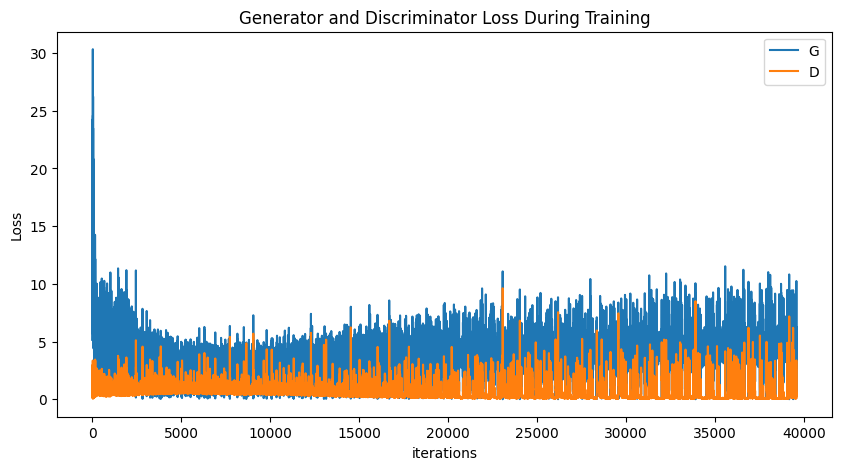

In [25]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Real Images vs. Fake Images**





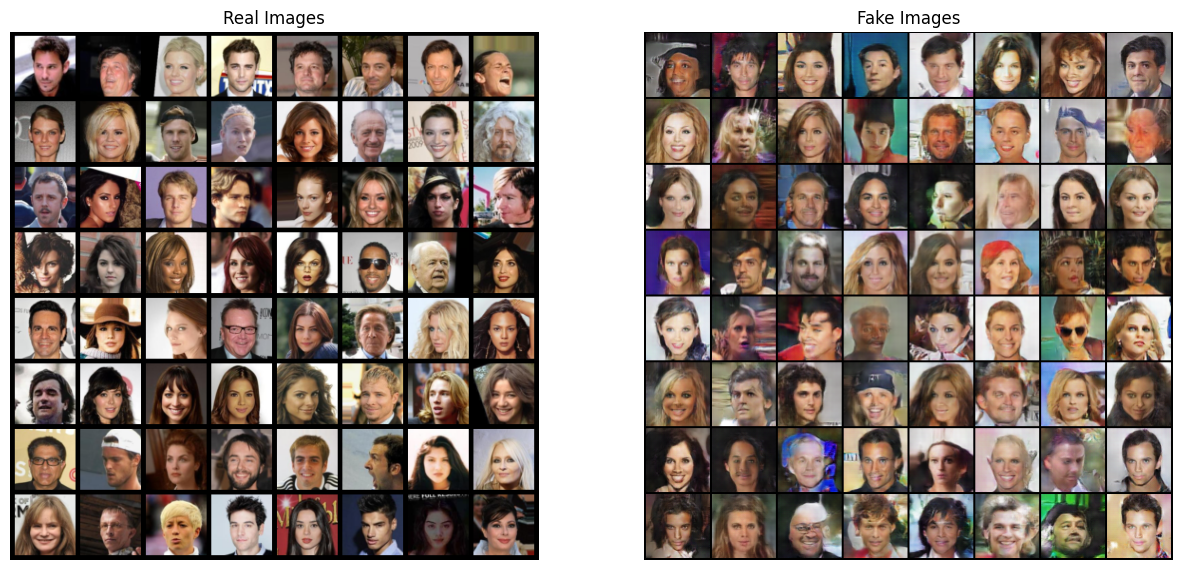

In [27]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [28]:
torch.save(netG.state_dict(), 'netG_model.pth')

In [29]:
torch.save(netD.state_dict(), 'netD_model.pth')

## Testing with Unseen data

### PreProcessing

In [6]:
original_fake_paths = []

for dirname, _, filenames in tqdm(os.walk('kaggle/input/fake face/')):
    for filename in filenames:
        original_fake_paths.append([os.path.join(dirname, filename), filename])

0it [00:00, ?it/s]

In [7]:
save_dir = 'kaggle/tmp/fake/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [11]:
fake_paths = [save_dir + filename for _, filename in original_fake_paths]

In [ ]:
for path, filename in tqdm(original_fake_paths):
    try:
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224))
        cv2.imwrite(os.path.join(save_dir, filename), img)
    except Exception as e:
        print(str(e))

In [12]:
train_fake_paths, test_fake_paths = train_test_split(fake_paths, test_size=0.2, random_state=2019)

fake_train_df = pd.DataFrame(train_fake_paths, columns=['filename'])
fake_train_df['class'] = 'FAKE'

fake_test_df = pd.DataFrame(test_fake_paths, columns=['filename'])
fake_test_df['class'] = 'FAKE'

In [13]:
real_dir = 'kaggle/input/celeba/img_align_celeba/img_align_celeba/'
eval_partition = pd.read_csv('kaggle/input/celeba/list_eval_partition.csv')

eval_partition['filename'] = eval_partition.image_id.apply(lambda st: real_dir + st)
eval_partition['class'] = 'REAL'

In [14]:
real_train_df = eval_partition.query('partition in [0, 1]')[['filename', 'class']]
real_test_df = eval_partition.query('partition == 2')[['filename', 'class']]

In [15]:
train_df = pd.concat([real_train_df, fake_train_df])
test_df = pd.concat([real_test_df, fake_test_df])

In [16]:
test_df.head()

,filename,class
182637,kaggle/input/celeba/img_align_celeba/img_align...,REAL
182638,kaggle/input/celeba/img_align_celeba/img_align...,REAL
182639,kaggle/input/celeba/img_align_celeba/img_align...,REAL
182640,kaggle/input/celeba/img_align_celeba/img_align...,REAL
182641,kaggle/input/celeba/img_align_celeba/img_align...,REAL


## Combined Dataset is ready

## Custom Dataset


In [17]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        filename = self.dataframe.iloc[index]['filename']
        class_label = self.dataframe.iloc[index]['class']
        image = Image.open(filename).convert('RGB')
        transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

        image = transform(image)

        return image, class_label

In [18]:
test_df['class'].replace({'REAL': 1, 'FAKE': 0}, inplace=True)

In [19]:
from torch.utils.data import DataLoader
dataset = CustomDataset(test_df)
test_loader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=0)

device = torch.device('cuda')
classifier = torch.load('disc.pth').to(device)

In [20]:
total = 0
correct = 0

classifier.eval()
with torch.no_grad():
    
    for inputs, labels in test_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = classifier(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted = torch.squeeze(predicted)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print('Accuracy of the model on the test images: {:.2f}%'.format(accuracy))
        

Accuracy of the model on the test images: 39.16%


### The discriminator as a classifier for the detection of DeepFakes was able to achieve only ~40% accuracy on a completely unseen dataset 